### Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense

In [2]:
# Constants
EMBEDDING_DIM = 128
LSTM_UNITS = 256
BATCH_SIZE = 32
EPOCHS = 10
VALIDATION_SPLIT = 0.2
DATA_PATH = "../data/spelling/autocorrect_dataset.csv"

### Loading and process data

In [3]:
# Load the dataset
df = pd.read_csv(DATA_PATH)

In [4]:
def preprocess_text(text):
    """Lowercase and strip leading/trailing spaces from text."""
    return text.lower().strip()

In [53]:
# Preprocess the text
df['misspelled'] = df['misspelled'].apply(preprocess_text)
df['correct'] = df['correct'].apply(preprocess_text)

In [59]:
print(df.head())

  misspelled  correct
0     pirlng   piring
1        mio      mie
2    tornabo  tornado
3      lamqu    lampu
4      vdara    udara


**Tokenizes the input and output columns of a DataFrame**

In [82]:
def tokenize_text(df, input_column, output_column):
    # Add start and end tokens to the output column
    df[output_column] = df[output_column].apply(lambda x: '<start> ' + x + ' <end>')

    input_tokenizer = Tokenizer(oov_token='<OOV>')
    output_tokenizer = Tokenizer(oov_token='<OOV>')

    input_tokenizer.fit_on_texts(df[input_column])
    output_tokenizer.fit_on_texts(df[output_column])

    # Changed to using fitted tokenizers and input data from correct column
    input_sequences = input_tokenizer.texts_to_sequences(df[input_column])
    output_sequences = output_tokenizer.texts_to_sequences(df[output_column])

    return input_tokenizer, output_tokenizer

In [85]:
# Tokenize the text
input_tokenizer, output_tokenizer = tokenize_text(df, 'misspelled', 'correct')

In [87]:
print(input_tokenizer.word_index)
print(output_tokenizer.word_index)

{'<OOV>': 1, 'puluh': 2, 'belas': 3, 'lima': 4, 'dua': 5, 'tua': 6, 'enam': 7, 'muda': 8, 'ac': 9, 'empat': 10, 'tiga': 11, 'delapan': 12, 'sembilan': 13, 'tujuh': 14, 'cokelat': 15, 'bola': 16, 'diri': 17, 'kepala': 18, 'daur': 19, 'buah': 20, 'biru': 21, 'keras': 22, 'hati': 23, 'besi': 24, 'merah': 25, 'balas': 26, 'film': 27, 'ulang': 28, 'sakit': 29, 'tosca': 30, 'delas': 31, 'pulun': 32, 'pvluh': 33, 'bolas': 34, 'pelas': 35, 'puloh': 36, 'hijau': 37, 'pulvh': 38, 'rumah': 39, 'sepak': 40, 'quluh': 41, 'puluk': 42, 'rendah': 43, 'belaz': 44, 'poluh': 45, 'belax': 46, 'buahan': 47, 'buluh': 48, 'lalu': 49, 'flora': 50, 'angkat': 51, 'lelah': 52, 'pel': 53, 'belos': 54, 'dva': 55, 'konflik': 56, 'bua': 57, 'lap': 58, 'percaya': 59, 'lina': 60, 'figa': 61, 'ruda': 62, 'beles': 63, 'belis': 64, 'lira': 65, 'pua': 66, 'doa': 67, 'global': 68, 'lunak': 69, 'luka': 70, 'vlog': 71, 'tvjuh': 72, 'tjga': 73, 'lama': 74, 'lari': 75, 'alis': 76, 'dalam': 77, 'ljma': 78, 'lagu': 79, 'fiskal':

Creates padded input and output sequences

In [88]:
def create_sequences(input_tokenizer, output_tokenizer, df, input_column, output_column):

    input_sequences = input_tokenizer.texts_to_sequences(df[input_column])
    output_sequences = output_tokenizer.texts_to_sequences(df[output_column])

    max_input_len = max([len(seq) for seq in input_sequences])
    max_output_len = max([len(seq) for seq in output_sequences])

    input_padded = pad_sequences(input_sequences, maxlen=max_input_len, padding='post')
    output_padded = pad_sequences(output_sequences, maxlen=max_output_len, padding='post')

    return input_padded, output_padded, max_input_len, max_output_len


In [89]:
# Create sequences and pad them
input_padded, output_padded, max_input_len, max_output_len = create_sequences(
  input_tokenizer, output_tokenizer, df, 'misspelled', 'correct'
    )

In [96]:
# Print the shapes of the padded sequences
print("Input Padded Shape:", input_padded.shape)
print("Output Padded Shape:", output_padded.shape)
print("Max Input Length:", max_input_len)
print("Max Output Length:", max_output_len)

Input Padded Shape: (149200, 2)
Output Padded Shape: (149200, 24)
Max Input Length: 2
Max Output Length: 24


**Prepares decoder inputs and outputs by adding start and end tokens**

In [98]:
def prepare_decoder_inputs_outputs(output_sequences, max_output_len):
    input_sequences = [seq[:-1] for seq in output_sequences]
    output_sequences = [seq[1:] for seq in output_sequences]
    input_padded = pad_sequences(input_sequences, maxlen=max_output_len, padding='post')
    output_padded = pad_sequences(output_sequences, maxlen=max_output_len, padding='post')

    return input_padded, output_padded

In [91]:
# Prepare decoder inputs and outputs
decoder_input_padded, decoder_output_padded = prepare_decoder_inputs_outputs(
  output_padded, max_output_len
    )


In [100]:
# Print shapes and examples
print("Decoder Input Padded Shape:", decoder_input_padded.shape)
print("Decoder Output Padded Shape:", decoder_output_padded.shape)

Decoder Input Padded Shape: (149200, 24)
Decoder Output Padded Shape: (149200, 24)


In [92]:
def create_model(input_vocab_size, output_vocab_size, embedding_dim, lstm_units):
    """Creates and compiles the Seq2Seq model."""
    # Encoder
    encoder_inputs = Input(shape=(None,))
    encoder_embedding = Embedding(input_vocab_size, embedding_dim)(encoder_inputs)
    encoder_lstm, state_h, state_c = LSTM(lstm_units, return_state=True)(encoder_embedding)

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(output_vocab_size, embedding_dim)(decoder_inputs)
    decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=False)
    decoder_outputs = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])
    decoder_dense = Dense(output_vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [30]:
# Define vocabulary sizes and model parameters
input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1
embedding_dim = 128
lstm_units = 256

In [31]:
# Create the model
model = create_model(input_vocab_size, output_vocab_size, embedding_dim, lstm_units)

In [34]:
# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, None, 128)      │      5,555,072 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, None, 128)      │         92,416 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 256), (None,   │        394,240 │ embedding_2[0][0]      │
│                           │ 256), (None, 256)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, None, 256)      │        394,240 │ embedding_3[0][0],     │
│                           │                        │                │ lstm_2[0][1],          │
│                           │                        │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, None, 722)      │        185,554 │ lstm_3[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 19,864,568 (75.78 MB)

 Trainable params: 6,621,522 (25.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,243,046 (50.52 MB)

In [32]:
# Train the model
history = model.fit(
  [input_padded, decoder_input_padded],
  np.expand_dims(decoder_output_padded, -1),  # Ensure output shape matches sparse categorical cross-entropy requirements
  batch_size=32,
  epochs=10,
  validation_split=0.2
)

Epoch 1/10
3730/3730 ━━━━━━━━━━━━━━━━━━━━ 420s 112ms/step - accuracy: 0.7374 - loss: 1.7001 - val_accuracy: 0.7981 - val_loss: 0.9679
Epoch 2/10
3730/3730 ━━━━━━━━━━━━━━━━━━━━ 431s 115ms/step - accuracy: 0.8217 - loss: 0.7578 - val_accuracy: 0.8751 - val_loss: 0.6053
Epoch 3/10
3730/3730 ━━━━━━━━━━━━━━━━━━━━ 427s 111ms/step - accuracy: 0.9099 - loss: 0.3581 - val_accuracy: 0.9233 - val_loss: 0.4259
Epoch 4/10
3730/3730 ━━━━━━━━━━━━━━━━━━━━ 435s 110ms/step - accuracy: 0.9591 - loss: 0.1513 - val_accuracy: 0.9388 - val_loss: 0.3872
Epoch 5/10
3730/3730 ━━━━━━━━━━━━━━━━━━━━ 475s 119ms/step - accuracy: 0.9778 - loss: 0.0774 - val_accuracy: 0.9471 - val_loss: 0.4051
Epoch 6/10
3730/3730 ━━━━━━━━━━━━━━━━━━━━ 503s 119ms/step - accuracy: 0.9875 - loss: 0.0430 - val_accuracy: 0.9521 - val_loss: 0.4400
Epoch 7/10
3730/3730 ━━━━━━━━━━━━━━━━━━━━ 504s 120ms/step - accuracy: 0.9920 - loss: 0.0265 - val_accuracy: 0.9545 - val_loss: 0.4838
Epoch 8/10
3730/3730 ━━━━━━━━━━━━━━━━━━━━ 454s 122ms/step - ac

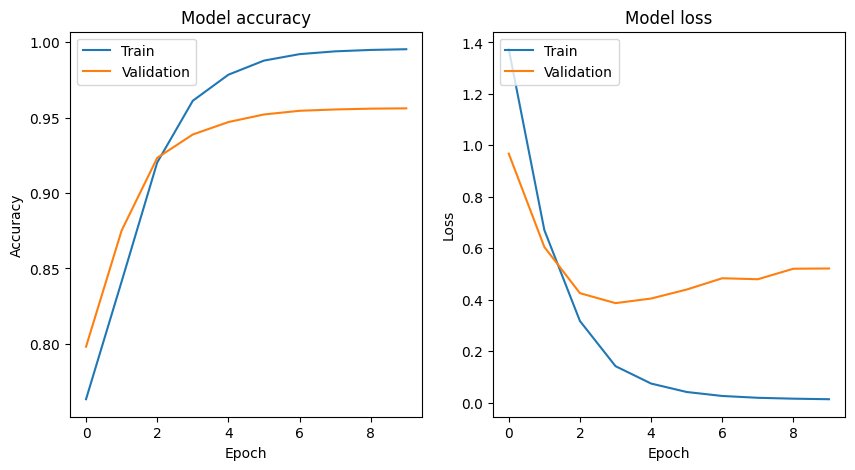

In [33]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [37]:
# Save the model
model.save("modelSpellChacker.h5")

In [36]:
# Save model architecture as JSON
model_json = model.to_json()
with open("modelSpellChacker.json", "w") as json_file:
  json_file.write(model_json)